In [1]:
import sys

sys.path.append("../")

In [2]:
import requests
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from arch import arch_model
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from datetime import datetime, timedelta

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from statsmodels.tsa.stattools import adfuller as adf

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
# DATA_PATH = '/mnt/c/Users/vmodg/source/repos/BeanRepos/crypto-pair-trading/data/'
# TIMEFRAME = '1d'
# lookback = 1000

TIMEFRAME = '1h'
lookback = 30*4

# TIMEFRAME = '15m'
# lookback = 30*2


DATA_PATH = f'/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/'


In [5]:
API_BASE = 'https://fapi.binance.com/fapi/v1/'
TIMEFRAME = '1h'

LABELS = [
    'open_time',
    'open',
    'high',
    'low',
    'close',
    'volume',
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]

DROP_COLUMNS=[
    'close_time',
    'quote_asset_volume',
    'number_of_trades',
    'taker_buy_base_asset_volume',
    'taker_buy_quote_asset_volume',
    'ignore'
]


def get_batch(symbol, interval='1m', start_time=0, limit=1000):
    """Use a GET request to retrieve a batch of candlesticks. Process the JSON into a pandas
    dataframe and return it. If not successful, return an empty dataframe.
    """

    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'limit': limit
    }
    try:
        # timeout should also be given as a parameter to the function
        response = requests.get(f'{API_BASE}klines', params, timeout=30)
    except requests.exceptions.ConnectionError:
        print('Connection error, Cooling down for 5 mins...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    except requests.exceptions.Timeout:
        print('Timeout, Cooling down for 5 min...')
        time.sleep(5 * 60)
        return get_batch(symbol, interval, start_time, limit)

    if response.status_code == 200:
        return pd.DataFrame(response.json(), columns=LABELS)
    
    print(f'Got erroneous response back {symbol}: {response}. {response.text}')
    return pd.DataFrame([])


def get_candles(base, quote, start_date: datetime, interval='1m'):
    batches = []

    last_timestamp = int(start_date.timestamp()) * 1000
    # gather all candlesticks available, starting from the last timestamp loaded from disk or 0
    # stop if the timestamp that comes back from the api is the same as the last one
    previous_timestamp = None

    while previous_timestamp != last_timestamp:
        # stop if we reached data from today
        if datetime.fromtimestamp(last_timestamp / 1000) >= datetime.utcnow():
            break

        previous_timestamp = last_timestamp

        new_batch = get_batch(
            symbol=base + quote,
            interval=interval,
            start_time=last_timestamp
        )

        # requesting candles from the future returns empty
        # also stop in case response code was not 200
        if new_batch.empty:
            break

        last_timestamp = new_batch['open_time'].max()

        # sometimes no new trades took place yet on date.today();
        # in this case the batch is nothing new
        if previous_timestamp == last_timestamp:
            break

        batches.append(new_batch)
        last_datetime = datetime.fromtimestamp(last_timestamp / 1000)

        covering_spaces = 20 * ' '
        print(datetime.now(), base, quote, interval, str(last_datetime) + covering_spaces, end='\r', flush=True)

    if len(batches) > 0:
        # write clean version of csv to parquet
        df = pd.concat(batches, ignore_index=True)
        df.drop(columns=DROP_COLUMNS, inplace=True)
        df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
        df.set_index(keys=['open_time'], inplace=True)
        return df



In [6]:
def get_data(symbols, timeframe):
    data = []

    for symbol in symbols:

        # print(p)
        df = get_candles(
            base=symbol,
            quote="USDT",
            start_date=datetime.utcnow() - timedelta(days=lookback),
            interval=timeframe,
        )
        if df is None:
            continue

        df.rename(columns={"close": symbol}, inplace=True)
        # the data is too long, just limit to recent period
        log = np.log(df[symbol].astype(np.float32))
        data.append(log)

    df = pd.concat(data, axis=1)
    df = df.dropna(axis=1, how="all")
    return df


In [7]:
# symbols = pd.read_csv(f'/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/symbols.csv')['symbol'].values.tolist()
symbols = ['BTCUSDT',
'ETHUSDT',
'XRPUSDT',
'LTCUSDT',
'ETCUSDT',
'LINKUSDT',
'XLMUSDT',
'ADAUSDT',
'BNBUSDT',
'ATOMUSDT',
'ALGOUSDT',
'DOTUSDT',
'SOLUSDT',
'AVAXUSDT',
'MATICUSDT',
'XMRUSDT',
'NEARUSDT',
'EOSUSDT',
'NEOUSDT',
'UNIUSDT']
symbols = [s.replace('USDT', '') for s in symbols]

data = []
start_time = datetime.utcnow() - timedelta(days=lookback)

for symbol in symbols:
    df = pd.read_csv(f'{DATA_PATH}{TIMEFRAME}/{symbol}-USDT.csv', parse_dates=['open_time'], index_col=['open_time'])
    df = df[df.index >= start_time].copy()
    # print('start time', df.index[-1].to_pydatetime())

    df1 = get_candles(
        base=symbol, 
        quote='USDT', 
        start_date=df.index[-1].to_pydatetime(),
        # end_date=datetime.now() - timedelta(days=15),
        interval=TIMEFRAME
    )
    if df1 is not None:
        df = pd.concat([df, df1])
        df = df[~df.index.duplicated(keep='first')]

    df.rename(columns={'close': symbol}, inplace=True)
    # the data is too long, just limit to recent period
    # log = np.log(df[symbol].astype(np.float32))
    data.append(df[symbol].astype(np.float32))

df = pd.concat(data, axis=1)
df = df.dropna(axis=1, how='all')
# df.dropna(inplace=True, how='any')

# our of sample
# df = df[df.index <= datetime.now() - timedelta(days=15)].copy()

df.tail()

IndexError: index -1 is out of bounds for axis 0 with size 0

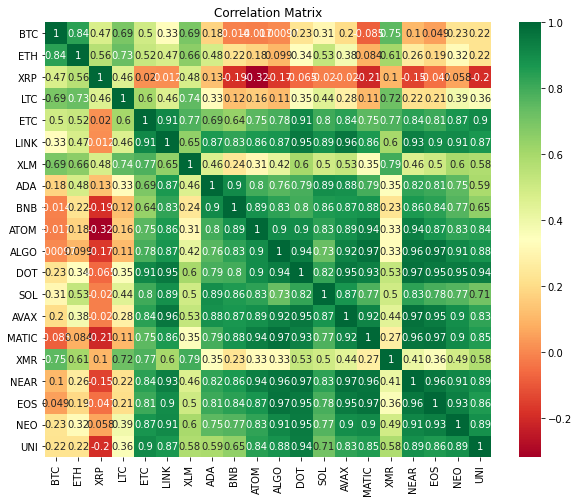

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Get the top 10 correlated pairs
top_corr_pairs = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
# Print the top 10 correlated pairs with their correlation coefficients (excluding same currency pairs)
print("Top 10 Correlated Pairs (excluding same currency pairs):")
count = 0
for pair in top_corr_pairs.index:
    coin1, coin2 = pair
    correlation_coefficient = correlation_matrix.loc[coin1, coin2]
    
    # Ignore pairs with the same currency
    if coin1 != coin2:
        print(f"{coin1} - {coin2}: {correlation_coefficient:.4f}")
        count += 1

    # Break the loop if we have printed the top 10 correlated pairs
    if count == 10:
        break

Top 10 Correlated Pairs (excluding same currency pairs):
NEAR - DOT: 0.9723
NEAR - AVAX: 0.9713
MATIC - ALGO: 0.9695
EOS - ALGO: 0.9680
MATIC - EOS: 0.9662
NEAR - ALGO: 0.9610
NEAR - MATIC: 0.9595
LINK - AVAX: 0.9587
NEAR - EOS: 0.9572
DOT - AVAX: 0.9540


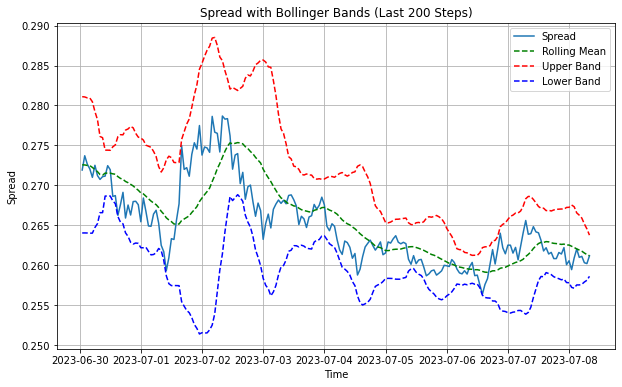

In [ ]:
# Assuming you have a DataFrame called 'df' with columns: NEAR, DOT...
lookback_steps = 200

# Calculate the spread
spread = df['BTC'] / df['ETH']

# Calculate the rolling mean and standard deviation
rolling_mean = spread.rolling(window=20).mean()
rolling_std = spread.rolling(window=20).std()

# Calculate the upper and lower Bollinger Bands
upper_band = rolling_mean + 3 * rolling_std
lower_band = rolling_mean - 3 * rolling_std

# Plot the last 'lookback_steps' steps of the spread with Bollinger Bands
plt.figure(figsize=(10, 6))
plt.plot(spread[-lookback_steps:], label='Spread')
plt.plot(rolling_mean[-lookback_steps:], color='g', linestyle='--', label='Rolling Mean')
plt.plot(upper_band[-lookback_steps:], color='r', linestyle='--', label='Upper Band')
plt.plot(lower_band[-lookback_steps:], color='b', linestyle='--', label='Lower Band')
plt.title(f'Spread with Bollinger Bands (Last {lookback_steps} Steps)')
plt.xlabel('Time')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()